#**Visualizing Intermediary Layers' Activation Output**

First, we load our trained CNN...

In [2]:
from tensorflow import keras
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

conv_net = keras.models.load_model("drive/My Drive/Teaching/Courses/BA 865/BA865-2025/Lecture Materials/Week 3/convnet_from_scratch.keras")

Mounted at /content/drive


Next, we load an impage to feed through the model...

259497/259497 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


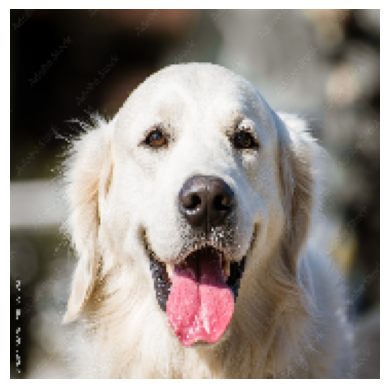

In [15]:
img_path = keras.utils.get_file(
    fname="1000_F_103975260_sOa1Cq2QNhenLiovsuFo39qRZbi0eXZM.jpg",
    origin="https://as1.ftcdn.net/jpg/01/03/97/52/1000_F_103975260_sOa1Cq2QNhenLiovsuFo39qRZbi0eXZM.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0) # add a dimension to the tensor (reflecting 'batch size' which my network will expect to receive as input)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [16]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []

# We are making a 'new' Keras model based on the single prior trained one, but with *many* different output branches.

# Iterate over all the layers in my prior model...
for layer in conv_net.layers:

    # If that layer is a 2D Convolution or a Max Pool layer...
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        print(f'Current layer is {layer.name} and its output shape is {layer.output.shape}')
        # Take that layer's outputs and name and append them to a list (we are going to use all of these as 'different' output layers, across a series of new models)
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

# Finally, define a new model as the trained model's inputs, mapped to the list of various layer outputs we created above.
# So, the new model takes images as input, and it will spit out a list of outputs (those associated with each successive Conv2D and pooling layer)
featuremap_model = keras.Model(inputs=conv_net.input, outputs=layer_outputs)

Current layer is conv2d and its output shape is (None, 178, 178, 32)
Current layer is max_pooling2d and its output shape is (None, 89, 89, 32)
Current layer is conv2d_1 and its output shape is (None, 87, 87, 64)
Current layer is max_pooling2d_1 and its output shape is (None, 43, 43, 64)
Current layer is conv2d_2 and its output shape is (None, 41, 41, 128)
Current layer is max_pooling2d_2 and its output shape is (None, 20, 20, 128)
Current layer is conv2d_3 and its output shape is (None, 18, 18, 256)
Current layer is max_pooling2d_3 and its output shape is (None, 9, 9, 256)
Current layer is conv2d_4 and its output shape is (None, 7, 7, 256)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


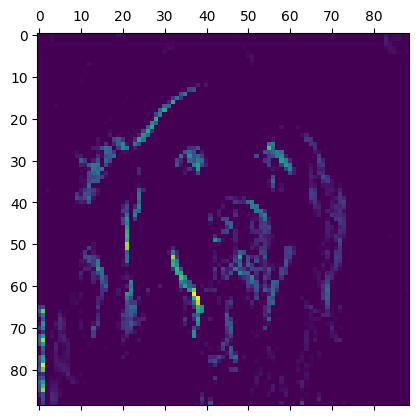

In [17]:
import matplotlib.pyplot as plt

featuremaps = featuremap_model.predict(img_tensor)

# What layer, and what filter do we want to look at?
layer = 1
filter = 4

# Let's plot the 1st feature map from the first Convolution layer.
# It seems to be detecting some edges.
plt.matshow(featuremaps[layer][0, :, :, filter], cmap="viridis")
plt.show()

In [18]:
images_per_row = 16
for layer_name, featuremap in zip(layer_names, featuremaps):
    n_features = featuremap.shape[-1]
    size = featuremap.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = featuremap[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

Output hidden; open in https://colab.research.google.com to view.

#**Class Activation Heatmaps**

Let's get the prediction for our dog image... note that our model actually does pretty well here; it predicts correctly.

In [19]:
preds = conv_net.predict(img_tensor)
print(f'Probability that this is a dog = {preds[0]}')

if np.round(preds[0]) == 0:
  print(f'Predicted class is cat.')
else:
  print(f'Predicted class is dog.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Probability that this is a dog = [0.8885119]
Predicted class is dog.


Let's get the names of the layers from our model...

In [20]:
for layer in conv_net.layers:
    print(layer.name)

input_layer
rescaling
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
conv2d_3
max_pooling2d_3
conv2d_4
flatten
dense


Now, we make two more Keras models. The first one just takes a picture as input and feeds it through the CNN layers of the trained model. The second takes the output from the CNN layers, and feeds it through the dense layer to a prediction output.

In [21]:
# The CNN base layers of our model.
last_conv_layer_name = "conv2d_4"
classifier_layer_names = [
    "flatten",
    "dense",
]
last_conv_layer = conv_net.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(conv_net.inputs, last_conv_layer.output)

# The final dense layers of our model.
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = conv_net.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

Now, we use GradientTape() to look at gradients of the class prediction w.r.t. activations (featuremaps) that are coming out of the last convolutional layer for our image. We get one gradient for each cell, in each feature-map.

In [26]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_tensor)
    print(f'CNN base output shape is: {last_conv_layer_output.shape}')
    tape.watch(last_conv_layer_output) # Watch forward pass through convolutional layers

    # NOTE: you have to call a model function (not the predict function for that model) for GradienTape to work!
    preds = classifier_model(last_conv_layer_output) # And watch the final prediction step from Conv output through to prediction...
    print(f'Prediction output is {preds}.')
    pr_dog = preds[0]

grads = tape.gradient(pr_dog, last_conv_layer_output) # Now get gradients of prediction with respect to each weight in each feature map.
print(f'grads shape is: {grads.shape}')

# Ignore the error... it's because our Input shape is set with a batch size of None, yet the image tensor has a specific first dimension of 1.

CNN base output shape is: (1, 7, 7, 256)
classifier_input shape: (None, 7, 7, 256)
last_conv_layer_output shape: (1, 7, 7, 256)
Prediction output is [[0.8885119]].
grads shape is: (1, 7, 7, 256)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 180, 180, 3))
  warnings.warn(msg)


Now, we construct our heatmap. We take the product of the feature maps for this particular image and the gradients that relate feature maps to prediction, to see what's most influencing the dog prediction here.

(256,)
(1, 7, 7, 256)


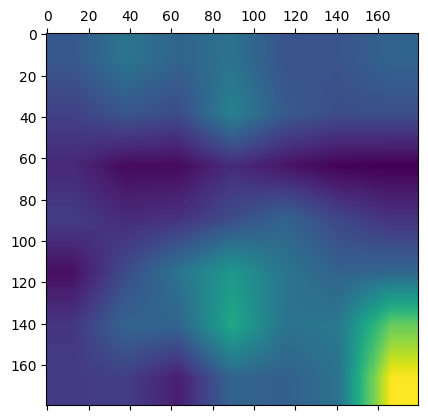

In [29]:
import cv2

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() # We average over all the gradients associated with a given feature-map.
print(pooled_grads.shape)

print(last_conv_layer_output.shape)

# Here we are multiplying the average gradient associated with each filter by that filter's output feature map... positive gradients are driving toward 1, negative toward 0.
# Basically... does the filter matter a lot * is the filter activated = heat!
for i in range(pooled_grads.shape[-1]):
    # Element wise multiplication, for a given index filter, multply all elements by the average gradient for that filter.
    last_conf_layer_output = last_conv_layer_output[:,:,:,i] * pooled_grads[i]

# Finally, for each cell in each of the 256, 7x7 feature maps, we've multiplied the cell value by the pooled gradient for that filter.
# Now, we are lininig up all those 7x7 featuremaps atop one another and averaging each cell position (was this position activated a lot or not much, across the 256 filters, collectively?)
# Higher values means we had more filters activated at this spot, that were all driving us systematically toward a prediction of 1. Smaller means closer to prediction of 0.
heatmap = np.mean(last_conv_layer_output, axis=-1)

heatmap = heatmap[-1]

# Here, we are are shifting all values to start at 0
heatmap = heatmap + -1*np.min(heatmap)
# Here, we are dividing by the max value so results all range from 0 to 1.
heatmap /= np.max(heatmap)

# Finally, we are upscaling the heatmap using interpolation (for smoothing the colors) so it matches the dimensionality of our input picture.
heatmap = cv2.resize(heatmap, (img_tensor.shape[2], img_tensor.shape[1])) # Resize to (width, height)

plt.matshow(heatmap)

The top of the head and the mouth positively impact our prediction, but so does the bottom right corner of the picture (this is bad!!).

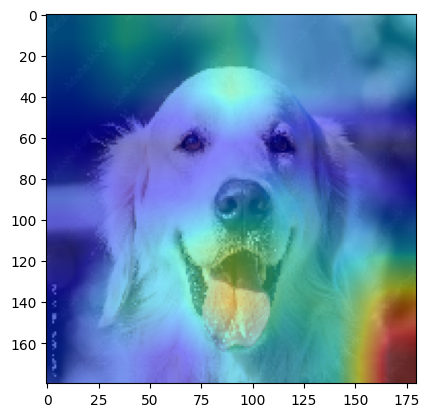

In [30]:
from matplotlib import colormaps as cm

img = img_tensor[0,:,:,:]

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.9 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

plt.imshow(superimposed_img)
plt.show()